Hello, this is my first kernel on kaggle. I welcome any suggestions and constructive criticisms.

Feel free to upvote and comment if this notebook is helpful to you in any way!

# **ModCloth Analytics - Size Prediction/Recommendation**

In this digital age, online shopping has become more prevalent than ever. Consumers have shifted from brick and mortar stores to shopping online due to the convenience and ease of doing so online - Shoppers can quickly search exactly for what they want, avoid long lines and crowds and do not have to make trips to go to the store. 

 

As most people are typically busy with school or work, it is easier and more appealing for them to shop at the convenience of their own homes. With such an easy access to a platform to buy clothes, comes problems. One of the main challenges is improper fitting as customers are not able to immediately try-out the clothes they buy online.

 

As such, having a good product size recommendation and fit prediction is critical in improving the customers’ shopping experiences and reducing product return rates. The fit related dataset collected from ModCloth, an American online retailer of indie and vintage-inspired women's clothing, could be used to address these challenges to improve the recommendation process.


# **Table of contents**

1. Data Exploration
2. Data Preparation
3. Feature Selection
4. Methods
5. Results

First, let's import the relevant libraries we need before we get started.

In [1]:
#Load libraries
import pandas as pd
import numpy as np
from scipy.stats import iqr

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
import joblib
import re
import os
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Data Exploration

Next, we can load first data file and get a feeling of how huge the dataset is.

Note: I have converted the original file to csv

In [2]:
# Load the data set
df = pd.read_csv("../input/modclothdf/original_dataset.csv" ,na_values = '""')
df = df[['item_id','waist','quality','cup size','hips','bra size','category','bust','height','user_name','length','fit','user_id','shoe size','shoe width','size']]
#Print the first 5 rows of the dataframe.
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,item_id,waist,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,size
0,123373,29.0,5.0,d,38.0,34.0,new,36.0,5ft 6in,Emily,just right,small,991571,NaN,NaN,7
1,123373,31.0,3.0,b,30.0,36.0,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,13
2,123373,30.0,2.0,b,NaN,32.0,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.0,NaN,7
3,123373,NaN,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,21
4,123373,NaN,5.0,b,NaN,36.0,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,18


Then I used df.info() to print a summary of a DataFrame which prints information about the DataFrame including the index dtype and column dtypes, non-null values and memory usage.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   item_id     82790 non-null  int64  
 1   waist       2882 non-null   float64
 2   quality     82722 non-null  float64
 3   cup size    76535 non-null  object 
 4   hips        56064 non-null  float64
 5   bra size    76772 non-null  float64
 6   category    82790 non-null  object 
 7   bust        11854 non-null  object 
 8   height      81683 non-null  object 
 9   user_name   82790 non-null  object 
 10  length      82755 non-null  object 
 11  fit         82790 non-null  object 
 12  user_id     82790 non-null  int64  
 13  shoe size   27915 non-null  float64
 14  shoe width  18607 non-null  object 
 15  size        82790 non-null  int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 10.1+ MB


Missing data can produce biased estimates and reduce the effectiveness of a machine learning model , leading to invalid conclusions. As such, it is important to identify columns with high percentage of missing data.​


In [4]:
missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().sum()/82790)*100})
missing_data

,total_missing,perc_missing
item_id,0,0.000000
waist,79908,96.518903
quality,68,0.082136
cup size,6255,7.555260
hips,26726,32.281677
bra size,6018,7.268994
category,0,0.000000
bust,70936,85.681846
height,1107,1.337118
user_name,0,0.000000


Here, we can identify that the columns 'waist' ,  'bust' and 'shoe width' have the greatest percentage of missing data of 96.5%, 85.7% and 77.5% respectively.​

This will be useful in data preparation where we will handle missing data to reduce bias.​

# **Data Preparation**

The DType of the height column is string (object) and is expressed in feet and inches. I decided to perform feature engineering where I parsed the height column to extract the height in a numerical quantity.​

I first split the height column into 2 columns ('h_foot' and 'h_inches') by space and extracted out the non-numeric characters. I used a formula to calculate the height to cm in the 'height' column and deleted the 2 columns.​

In [5]:
# split the height column by foot and inches
df[['h_foot', 'h_inches']] = df['height'].str.split(' ', 1, expand=True)

# extract only the numeric values from the string and covert to float
df['h_foot'] = df['h_foot'].str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float)
df['h_inches'] = df['h_inches'].str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float)

#ammend the height column to display height in cm
df["height"] = df["h_foot"].astype(float)*30.48 + df["h_inches"].astype(float)*2.54

# Dropping h_foot and h_inches columns as we do not need it anymore
del df['h_foot']
del df['h_inches']

#We can see by looking at the values which are not null, that bust should be an integer dtype. 
#However, there is a non-numeric value '37-39' in this column which needs to be extracted out so that we can safely convert the dtype to int. 
df['bust'] = df['bust'].str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float)


Data cleaning is an important part of data analysis. Df.dropna() is used to drop the rows with missing/null values. This ensures that the data is tidied up and will make the analysis much stronger. ​

I have also changed the datatype of the columns 'quality', 'waist', 'hips' and 'bra size' to float using astype pandas from string (object). ​

This step is necessary as it makes it easier to analyse the patterns and perform data visualisations using methods such as correlation matrix as most of these methods can only read numeric data.​

In [6]:
#drop rows with nan/missing values
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

#change datatype to str
df['quality'] = df['quality'].astype(float)
df['waist'] = df['waist'].astype(float)
df['hips'] = df['hips'].astype(float)
df['bra size'] = df['bra size'].astype(float)


Next, I used  Box Plot(Box & Whiskers) to show the distribution of numerical data and skewness through displaying the data quartiles and averages. It also helps me to identify the outliers so that I can extract them from the DataFrame. This is important as outliers can worsen the training process and lead to inaccurate  models and results. 

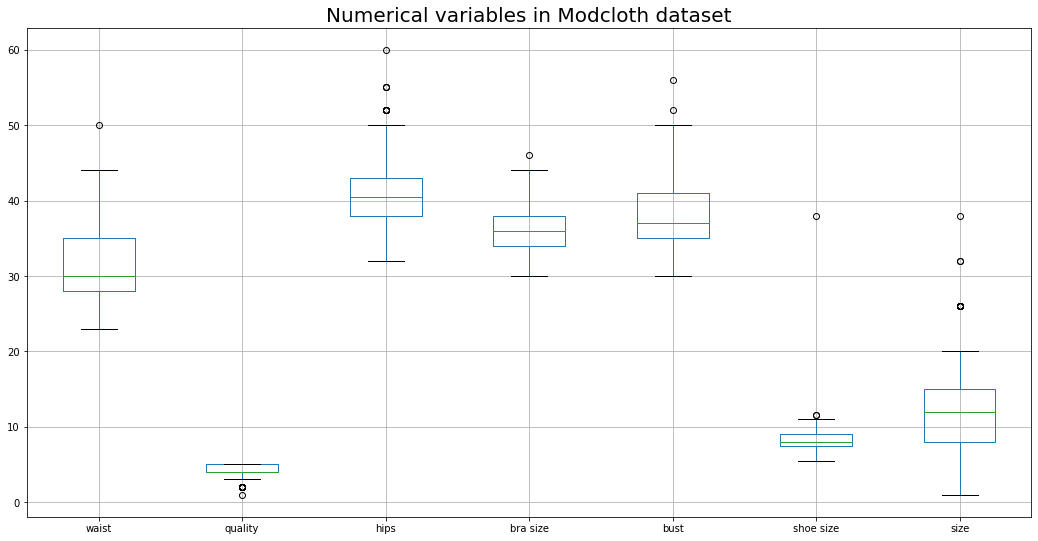

In [7]:
num_cols = ['waist','quality','hips','bra size','bust','shoe size','size']
plt.figure(figsize=(18,9))
df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset", fontsize=20)
plt.show()

# Feature Selection

Feature selection is important as it enables the machine learning algorithm to train faster and more accurately, reduces the complexity of a model and makes it easier to interpret. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and to improve the performance of the model. 

Correlation Matrix with Heatmap can be used to identify the features most related to the size column and determine the relationship/association between the 'size' column (which is the target variable) and the other variables. The darker the colour, the stronger the relationship with 'size'.

<AxesSubplot:>

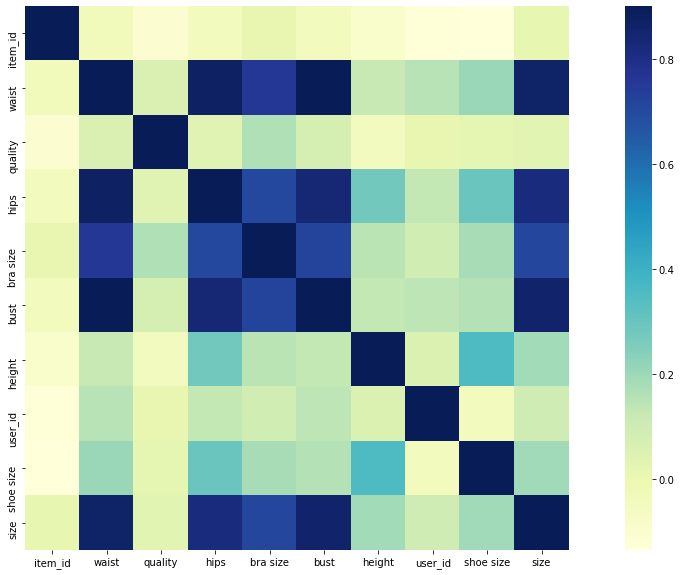

In [8]:
corrmat = df.corr()
plt.subplots(figsize=(20, 10))
sns.heatmap(corrmat, vmax=.9, cmap="YlGnBu", square=True)

From the matrix, I can deduce that the columns 'waist', 'hips', bra size' and 'bust' have the strongest association to size while columns like 'height' and 'shoe size' have a moderate association and the remaining columns like 'item id', 'quality' and 'user id' have the weakest relationship with 'size'.

In [9]:
## remove categorical data as the model in the next step can only take in numerical data
del df['cup size']
del df['category']
del df['user_name']
del df['length']
del df['fit']
del df['shoe width']

Another way to find the most important features is Feature Importance.

[0.11959173 0.16503776 0.06473398 0.12356107 0.092576   0.14207107
 0.09024568 0.11882887 0.08335383]


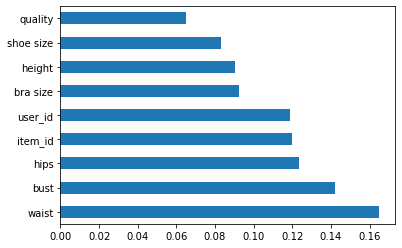

In [10]:
X = df.iloc[:,0:9]  #independent columns
y = df.iloc[:,-1]    #target column 

model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Feature importance gives me a score for each feature in the data. The higher the score, the more important or relevant the target feature is towards the output variable ('size'). Extra Tree Classifier is used for extracting the top features for the dataset. From the table, we can see that the most important features according to this algorithm are ‘waist’, ‘bust’ and ‘hips’ with scores greater than 0.1.

After using various methods to find the most important features which will be useful in improving the perormance of the model to predict sizes accurately, I identified that the most important features are 'waist', 'hips' and 'bust'. Thus, I dropped the unnecessary features which would not contribute to the efficacy of the model.

In [11]:
del df['quality']
del df['height']
del df['user_id']
del df['shoe size']
del df['bra size']

# Removing outliers

After dropping the irrelevant features, I removed the outliers by using the inter-quartile range to detect and remove most of the outliers of the remaining features. 

The data points that fall outside the (lower bound & outer bound) range that I have defined are to be extracted from the dataframe as outliers. The number (in this case, 1.5) controls the sensitivity of the range and hence, the decision rule. A bigger scale would make the outlier(s) to be considered as data point(s) while a smaller one would make some of the data point(s) to be perceived as outlier(s). Hence, 1.5 is the optimal number I have chosen in this scenerio.

In [12]:
cols = ['hips', 'bust', 'size', 'waist']
# Computing IQR
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
#defining range to identify data points lying outside the range(lower bound & upperbound). they are outliers).
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

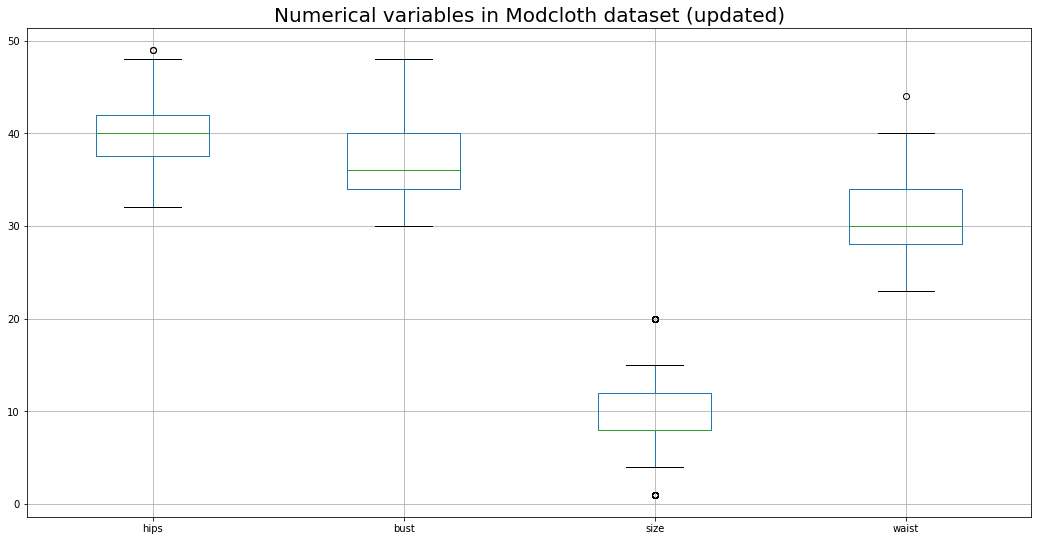

In [13]:
num_cols = ['hips', 'bust', 'size', 'waist'] # one or more
plt.figure(figsize=(18,9))
df[num_cols].boxplot()
plt.title("Numerical variables in Modcloth dataset (updated)", fontsize=20)
plt.show()

In [14]:
df['size'] = df['size'].astype(str)
df['item_id'] = df['item_id'].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 34264 to 65451
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   item_id  175 non-null    object 
 1   waist    175 non-null    float64
 2   hips     175 non-null    float64
 3   bust     175 non-null    float64
 4   size     175 non-null    object 
dtypes: float64(3), object(2)
memory usage: 8.2+ KB


# Methods

I trained the model using the following sklearn classification algorithms :

* Logistic Regression​

* Linear Discriminant Analysis​

* KNeighbours Classifier​

* Decision Tree Classifier​

* GaussianNB​

* SVC​

The models used to test were evaluated against one another using the results obtained and the boxplot plotted to visualize the result.​

In [15]:
# Split-out validation dataset
array = df.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [16]:
print(X)

[['412737' 27.0 36.0 32.0]
 ['414857' 35.0 41.0 42.0]
 ['416942' 35.0 46.0 37.0]
 ['418224' 38.0 43.0 41.0]
 ['423572' 28.0 39.0 34.0]
 ['423572' 30.0 40.0 35.0]
 ['424111' 37.0 45.0 41.0]
 ['424111' 29.0 41.0 34.0]
 ['424111' 38.0 47.0 46.0]
 ['426491' 29.0 36.0 34.0]
 ['427567' 38.0 47.0 46.0]
 ['428539' 29.0 37.0 34.0]
 ['429442' 29.0 36.0 34.0]
 ['431698' 29.0 41.0 34.0]
 ['440351' 31.0 44.0 40.0]
 ['441337' 25.0 36.0 32.0]
 ['441604' 30.0 40.0 39.0]
 ['441891' 30.0 40.0 39.0]
 ['445947' 30.0 39.0 36.0]
 ['447431' 30.0 42.0 37.0]
 ['449177' 32.0 41.0 39.0]
 ['453061' 32.0 35.0 36.0]
 ['453244' 37.0 45.0 41.0]
 ['456224' 29.0 36.0 39.0]
 ['458646' 29.0 36.0 39.0]
 ['459014' 28.0 36.0 36.0]
 ['459820' 25.0 33.0 32.0]
 ['461310' 25.0 35.0 34.0]
 ['464041' 27.0 34.0 34.0]
 ['464373' 29.0 41.0 34.0]
 ['467353' 26.0 35.0 34.0]
 ['468050' 28.0 39.0 36.0]
 ['469939' 31.0 38.0 36.0]
 ['470071' 28.0 36.0 35.0]
 ['470071' 28.0 39.0 36.0]
 ['471620' 25.0 33.0 32.0]
 ['471620' 44.0 47.0 48.0]
 

In [17]:
# Test options and evaluation metric
scoring = 'accuracy'


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

LR: 0.335714 (0.090633)
LDA: 0.578571 (0.121429)
KNN: 0.185714 (0.072843)
CART: 0.492857 (0.147945)
NB: 0.542857 (0.111575)
SVM: 0.335714 (0.090633)


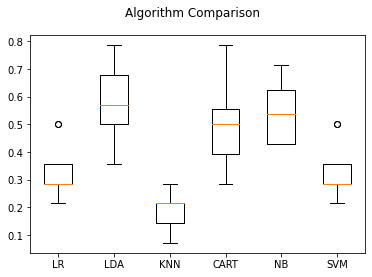

In [18]:
# Spot Check Algorithms
names = ['item_id', 'waist', 'hips', 'bust', 'size']
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The accuracy scores and standard deviation of each algorithm is shown, together with the box and whisker plot showing the spread of the accuracy scores across each cross-validation fold for each algorithm. 


LDA is the most accurate model with an accuracy score of 0.579, followed by NB and CART which have an accuracy score of 0.543 and 0.507 respectively. However, NB has the lowest standard deviation and smallest spread of accuracy scores among the 3 models. A smaller standard deviation is ideal as it means better consistency, predictability and quality.

In [19]:
# Make predictions on validation dataset
LR = LogisticRegression()
LR.fit(X_train, Y_train)
predictions = LR.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))


Accuracy:
0.37142857142857144

Confusion matrix:
[[ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  1  0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           8       0.37      1.00      0.54        13
           9       0.00      0.00      0.00         1

    accuracy                           0.37        35
   macro avg       0.05      0.12      0.07        35
weighted avg       0.14      0.37      0.20        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Make predictions on validation dataset
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, Y_train)
predictions = LDA.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))

Accuracy:
0.5714285714285714

Confusion matrix:
[[ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  5  0  0  0  4  0]
 [ 0  0  0  2  2  0  0  0]
 [ 0  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  1 12  0]
 [ 0  0  0  0  0  0  1  0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       1.00      0.56      0.71         9
          15       0.50      0.50      0.50         4
          20       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         3
           8       0.57      0.92      0.71        13
           9       0.00      0.00      0.00         1

    accuracy                           0.57        35
   macro avg       0.30      0.29      0.28        35
weighted avg       0.56      0.57      0.53        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Make predictions on validation dataset
KNN = KNeighborsClassifier()
KNN.fit(X_train, Y_train)
predictions = KNN.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))

Accuracy:
0.17142857142857143

Confusion matrix:
[[0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0]
 [0 0 2 2 2 1 2 0]
 [0 0 1 2 1 0 0 0]
 [0 0 1 1 0 0 1 0]
 [0 0 1 1 0 0 1 0]
 [1 0 4 2 3 1 2 0]
 [0 0 0 0 0 0 1 0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.22      0.22      0.22         9
          15       0.25      0.50      0.33         4
          20       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           8       0.22      0.15      0.18        13
           9       0.00      0.00      0.00         1

    accuracy                           0.17        35
   macro avg       0.09      0.11      0.09        35
weighted avg       0.17      0.17      0.16        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Make predictions on validation dataset
CART = DecisionTreeClassifier()
CART.fit(X_train, Y_train)
predictions = CART.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))

Accuracy:
0.5142857142857142

Confusion matrix:
[[0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 6 0 0 1 2 0]
 [0 0 1 1 2 0 0 0]
 [0 0 0 2 1 0 0 0]
 [0 0 0 0 0 2 1 0]
 [1 0 3 0 0 1 8 0]
 [0 0 0 0 0 0 1 0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.55      0.67      0.60         9
          15       0.33      0.25      0.29         4
          20       0.33      0.33      0.33         3
           4       0.40      0.67      0.50         3
           8       0.67      0.62      0.64        13
           9       0.00      0.00      0.00         1

    accuracy                           0.51        35
   macro avg       0.28      0.32      0.29        35
weighted avg       0.49      0.51      0.50        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Make predictions on validation dataset
NB = GaussianNB()
NB.fit(X_train, Y_train)
predictions = NB.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))

Accuracy:
0.5714285714285714

Confusion matrix:
[[ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  4  0  0  0  5  0]
 [ 0  0  0  3  1  0  0  0]
 [ 0  0  0  2  1  0  0  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  1 12  0]
 [ 0  0  0  0  0  0  1  0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       1.00      0.44      0.62         9
          15       0.60      0.75      0.67         4
          20       0.50      0.33      0.40         3
           4       0.00      0.00      0.00         3
           8       0.55      0.92      0.69        13
           9       0.00      0.00      0.00         1

    accuracy                           0.57        35
   macro avg       0.33      0.31      0.30        35
weighted avg       0.57      0.57      0.52        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Make predictions on validation dataset
svm = SVC()
svm.fit(X_train, Y_train)
predictions = svm.predict(X_validation)
print("Accuracy:")
print(accuracy_score(Y_validation, predictions))
print()
print("Confusion matrix:")
print(confusion_matrix(Y_validation, predictions))
print()
print("Classification report:")
print(classification_report(Y_validation, predictions))

Accuracy:
0.37142857142857144

Confusion matrix:
[[ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0  3  0]
 [ 0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  1  0]]

Classification report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         9
          15       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           8       0.37      1.00      0.54        13
           9       0.00      0.00      0.00         1

    accuracy                           0.37        35
   macro avg       0.05      0.12      0.07        35
weighted avg       0.14      0.37      0.20        35



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Results

Predicting size for item 424111 GaussianNB based on:
* 24in waist
* 34in hips
* 31in bust

In [25]:
print(NB.predict([[424111,24,34,31]]))


['4']


Predicting size for item 424111 using GaussianNB model based on:

* 35in waist
* 35in hips
* 42in bust

In [26]:
print(NB.predict([[424111,35,45,42]]))


['20']
